In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import netCDF4 as nc
import dask
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
def monthly_data_prep(folder_path, extension):
    # target_files = [f for f in files if f.endswith(extension)]
    target_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extension)]

    flattened_frames = []

    for file in target_files: 
        ds = xr.open_dataset(file, engine='netcdf4')
        df = ds.to_dataframe()
        flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
        flattened['valid_time'] = flattened['valid_time'].dt.date
        flattened = flattened.drop(columns=['number'])
        flattened_frames.append(flattened)
        
    flattened_0, flattened_1 = flattened_frames 

    if flattened_0["valid_time"].equals(flattened_1["valid_time"]):
        combined = flattened_0.merge(flattened_1, left_index=True, right_index=True)
        combined = combined.drop(columns=['valid_time_y', 'latitude_y', 'longitude_y'])
        combined = combined.rename(columns={'valid_time_x': 'valid_time', 'latitude_x': 'latitude', 'longitude_x': 'longitude'})
        return combined
    else:
        print('Dataframes do not have the same valid time.')
        return None

- siconc = sea ice concentration
- rsn = snow density
- sst = sea surface temperature
- sd = snow depth
- t2m = 2m temperature
- tp = total percipitation
- avg_smr = average snow melt rate

In [16]:
combined = monthly_data_prep(os.getcwd(), '.nc')

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


In [ ]:
# for the first plot, group by valid time and average over the latitude and longitude
grouped = combined.groupby('valid_time').agg('mean').reset_index()

# restrict timeframe to 1996 - 2017
grouped = grouped[(grouped['valid_time'] >= pd.Timestamp('1996-01-01')) & (grouped['valid_time'] <= pd.Timestamp('2017-12-31'))].reset_index(drop=True)

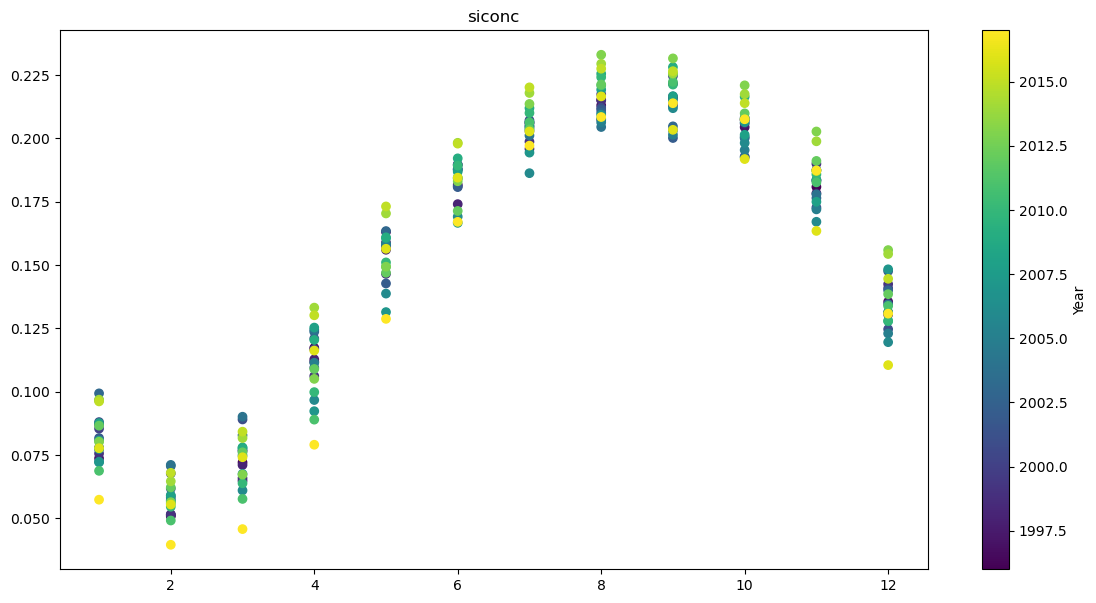

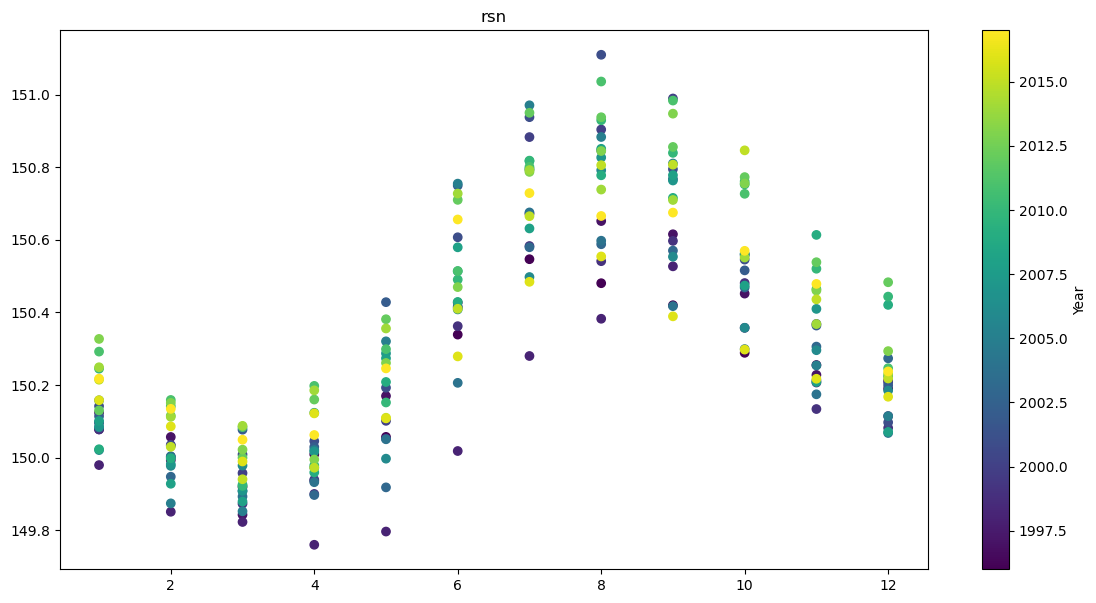

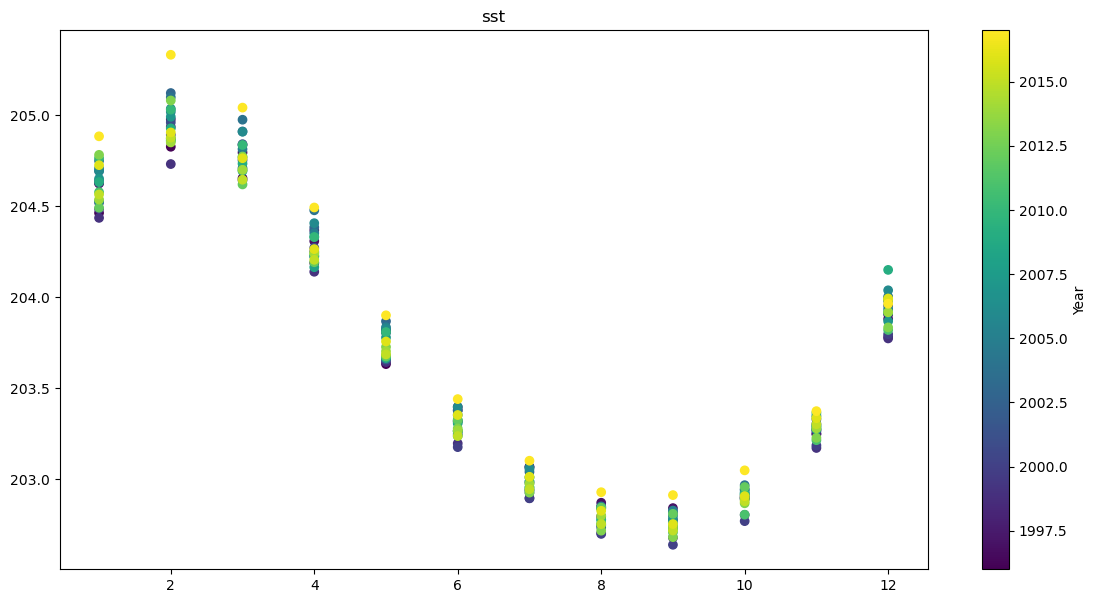

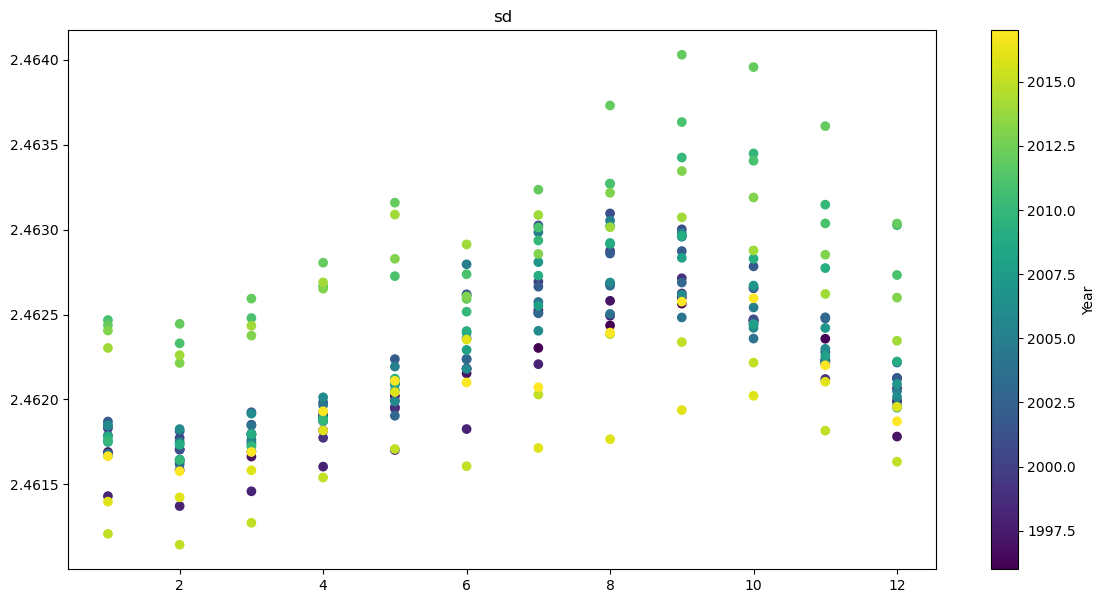

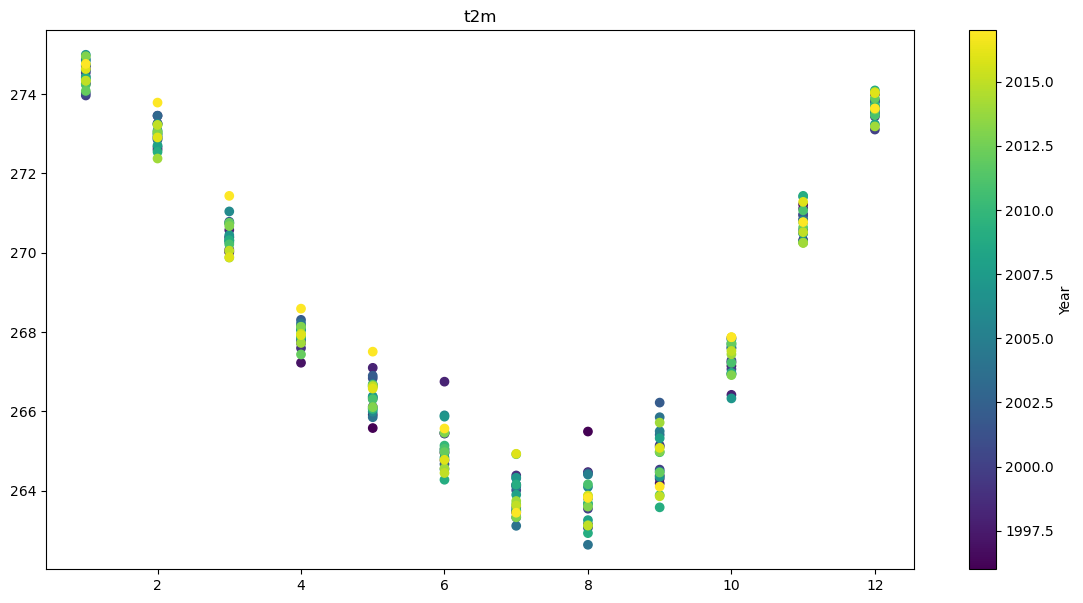

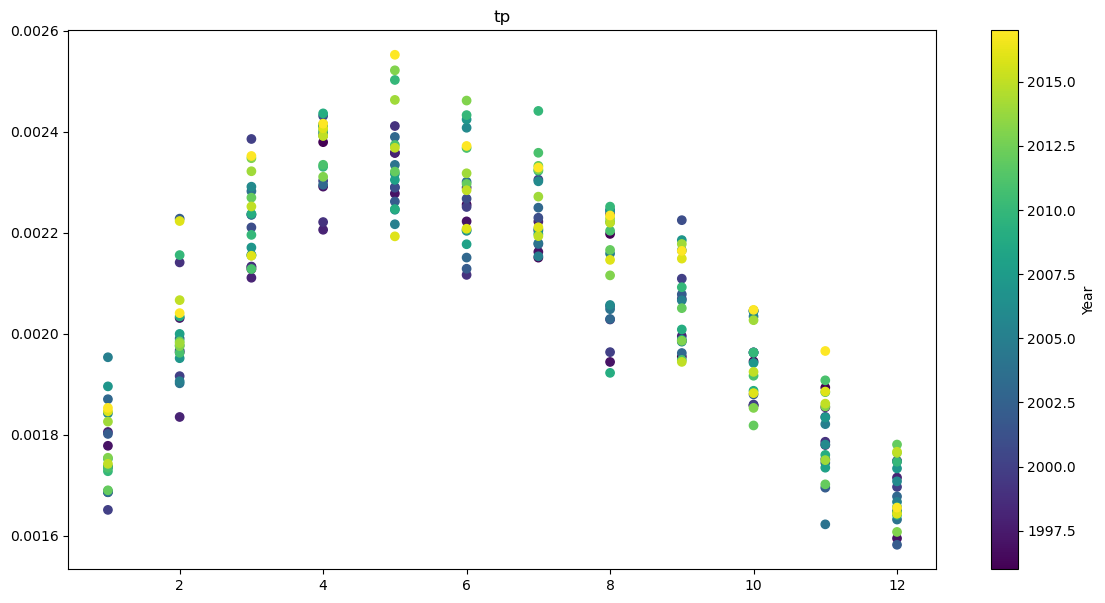

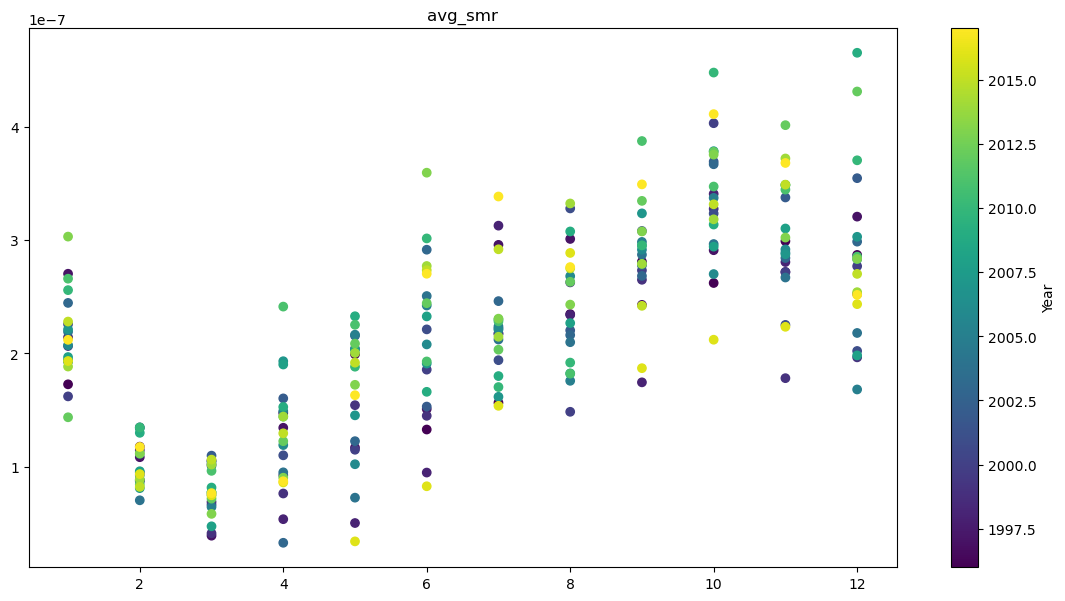

In [41]:
columns = grouped.columns[3:]
grouped['valid_time'] = pd.to_datetime(grouped['valid_time'])   

for column in columns:
    plt.figure(figsize=(14, 7))
    
    grouped['year'] = grouped['valid_time'].dt.year
    grouped['month'] = grouped['valid_time'].dt.month
    # Extract year and month from the 'month' column (assuming it's in datetime format)


    # Map years to colors
    scatter = plt.scatter(grouped['month'], grouped[column], 
                          c=grouped['year'], cmap='viridis')
    
    # Add colorbar
    plt.colorbar(scatter, label='Year')

    plt.title(column)
    plt.show()

In [ ]:
# calculate the actual numbers --> means per year, standard deviations per year etc
grouped['year'] = grouped['valid_time'].dt.year
grouped['month'] = grouped['valid_time'].dt.month


## Calculate statistics for reference period 1961-1990

In [ ]:

files_rp = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/monthly_data/reference_period'
print(os.listdir(files_rp))
reference_period_df = monthly_data_prep(folder_path=files_rp, extension= '.nc')

['.DS_Store', 'data_1_rp.nc', 'data_0_rp.nc']


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


In [4]:
print(reference_period_df.head)

<bound method NDFrame.head of           valid_time  latitude  longitude        tp  avg_smr  siconc  \
0         1961-01-01     -86.0    -162.00  0.000784      0.0     0.0   
1         1961-01-01     -86.0    -161.75  0.000797      0.0     0.0   
2         1961-01-01     -86.0    -161.50  0.000811      0.0     0.0   
3         1961-01-01     -86.0    -161.25  0.000824      0.0     0.0   
4         1961-01-01     -86.0    -161.00  0.000837      0.0     0.0   
...              ...       ...        ...       ...      ...     ...   
41757475  1990-12-01     -38.0     -13.00  0.003168      0.0     0.0   
41757476  1990-12-01     -38.0     -12.75  0.003065      0.0     0.0   
41757477  1990-12-01     -38.0     -12.50  0.003090      0.0     0.0   
41757478  1990-12-01     -38.0     -12.25  0.003093      0.0     0.0   
41757479  1990-12-01     -38.0     -12.00  0.003119      0.0     0.0   

                 rsn         sst    sd         t2m  
0         300.000000    0.000000  10.0  256.732452  

## Center Data around Reference period

In [ ]:
 # center all columns at their mean and make individual values percentages:
 # 1961 -1990 als Referenzperiode nehmen! 

rp_grouped = reference_period_df.groupby('valid_time').agg('mean').reset_index()


In [30]:
columns = rp_grouped.columns[3:]
# calculate climate anomalies
grouped_anomaly = grouped.copy()
for column in columns:
    grouped_anomaly[column] = (grouped[column] - rp_grouped[column].mean()) / rp_grouped[column].std()

print(grouped_anomaly.head())

   valid_time  latitude  longitude    siconc       rsn       sst        sd  \
0  1996-01-01     -62.0      -87.0 -1.245543 -0.876851  1.066793 -2.690519   
1  1996-02-01     -62.0      -87.0 -1.875971 -1.067887  1.522181 -2.687103   
2  1996-03-01     -62.0      -87.0 -1.506611 -1.235122  1.306121 -2.678045   
3  1996-04-01     -62.0      -87.0 -0.721336 -1.032133  0.722110 -2.665722   
4  1996-05-01     -62.0      -87.0  0.073038 -0.923663  0.026592 -2.653754   

        t2m        tp   avg_smr  
0  1.586423 -0.937883 -0.596335  
1  1.332338 -0.024748 -1.113876  
2  0.510749  0.633767 -1.230139  
3  0.039648  1.640437 -0.834147  
4 -0.610952  1.554888 -0.347133  


## Monthly Plots

In [87]:
# columns = grouped.columns[3:]  

# for column in columns:
#     plt.figure(figsize=(14, 7))
    
#     # Extract year and month from the 'month' column (assuming it's in datetime format)


#     # Map years to colors
#     scatter = plt.scatter(grouped['month'], grouped[column], 
#                           c=grouped['year'], cmap='viridis')
    
#     # Add colorbar
#     plt.colorbar(scatter, label='Year')

#     plt.title(column)
#     plt.show()



def plot_monthly(df, columns, deg):

    # only keep values from years 1996, 2000, 2004, 2008, 2012, 2016
    df = df[df['year'].isin([1996,  2003,  2010, 2017])]
    


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        if column == 'siconc':
            title = 'Sea Ice Concentration'
        elif column == 'rsn':
            title = 'Snow Density'
        elif column == 'sst':
            title = 'Sea Surface Temperature'
        elif column == 'sd':
            title = 'Snow Depth'
        elif column == 't2m':
            title = '2m Temperature'
        elif column == 'tp':
            title = 'Total Precipitation'
        elif column == 'avg_smr':
            title = 'Average Snowmelt Rate'
        else: 
            title = column

       

        #scatter = plt.scatter(df['month'], df[column], c = 'black')
        scatter = plt.scatter(df['month'], df[column], 
                          c=df['year'], cmap='viridis')
    
        # Add colorbar
        plt.colorbar(scatter, label='Year')


        # # add regression line
        # z = np.polyfit(df['month'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        # p = np.poly1d(z)
        # plt.plot(df['month'],p(df['month']), linestyle = "-", c = 'red', linewidth = 0.3)


        plt.xlabel('month')
        plt.title(title)
        plt.tight_layout()
        plt.show()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/3741837649.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()


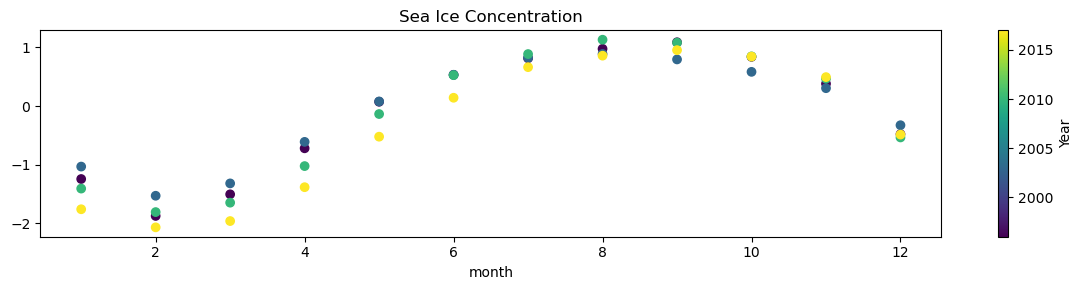

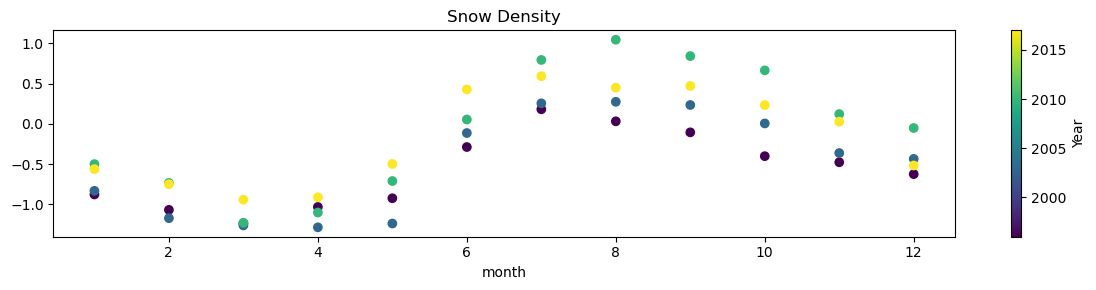

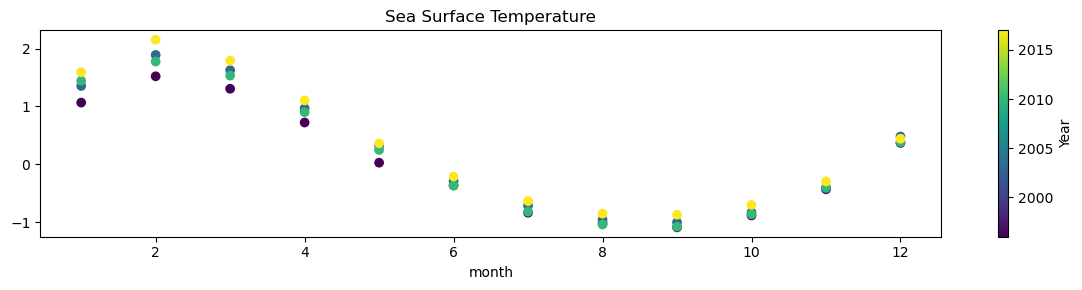

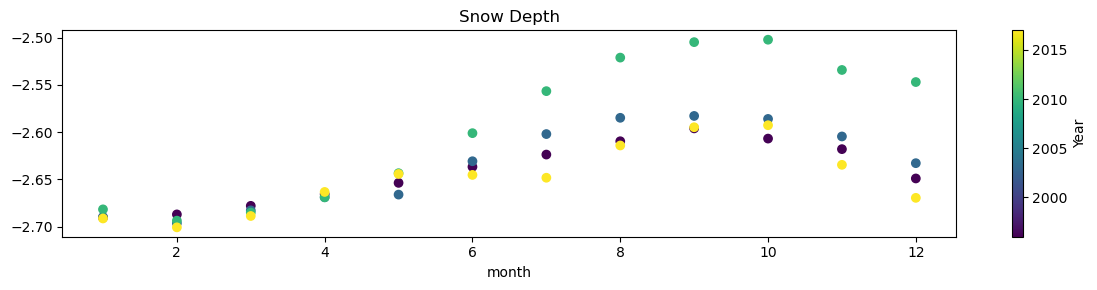

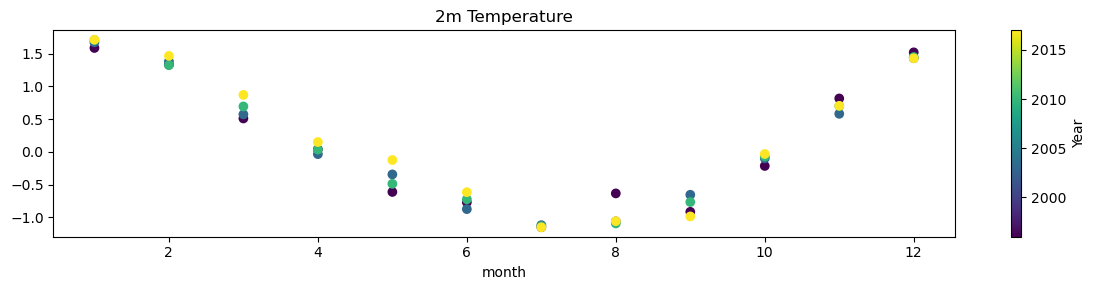

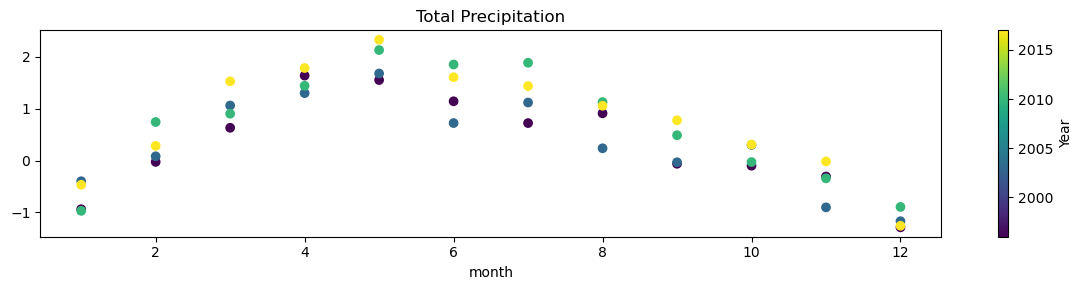

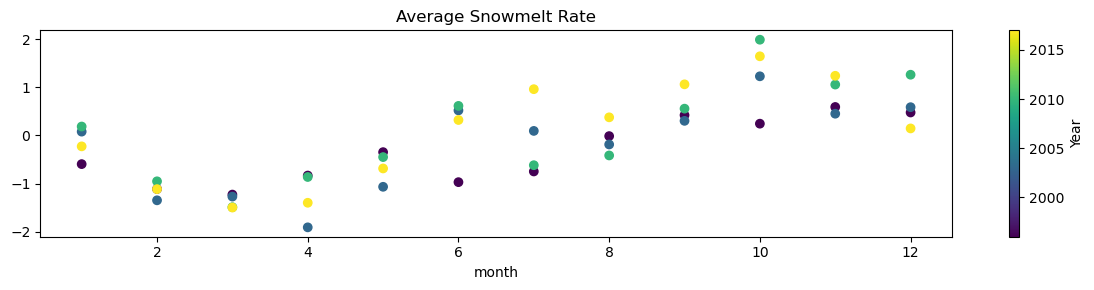

In [88]:
means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()
columns = means_monthly.columns[4:]
plot_monthly(means_monthly, columns, 1)

## Yearly Plots


In [33]:
grouped_anomaly['valid_time'] = pd.to_datetime(grouped_anomaly['valid_time'])

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/2810281515.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped_anomaly.groupby('year').agg('mean').reset_index()


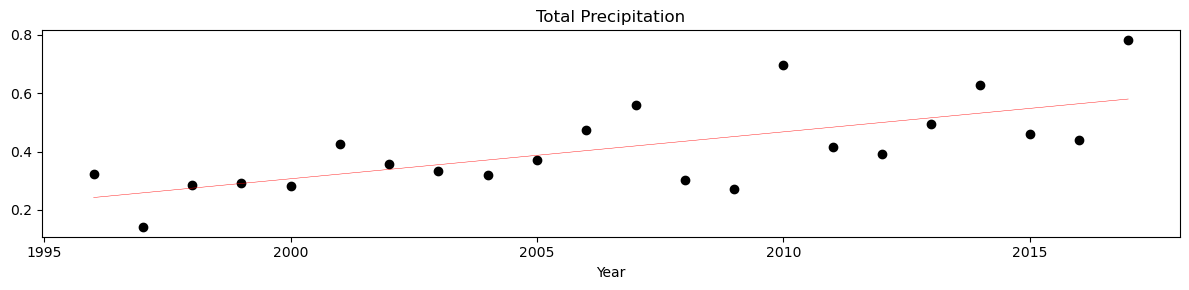

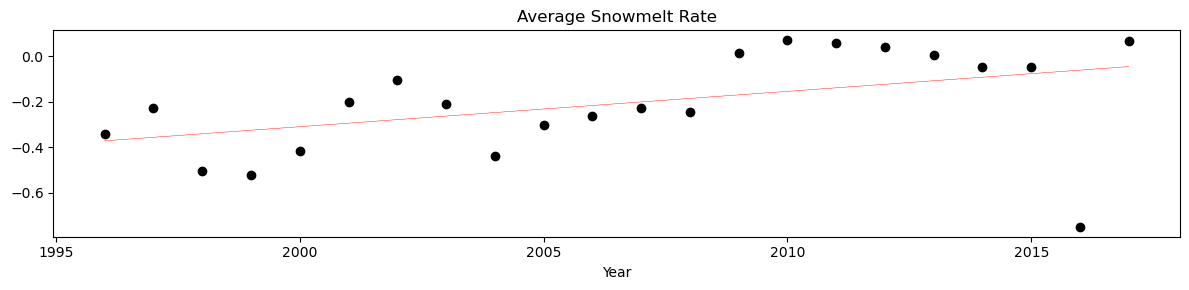

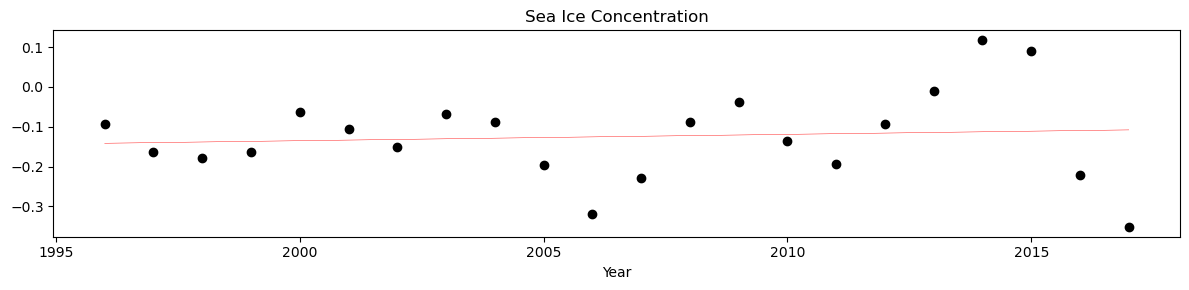

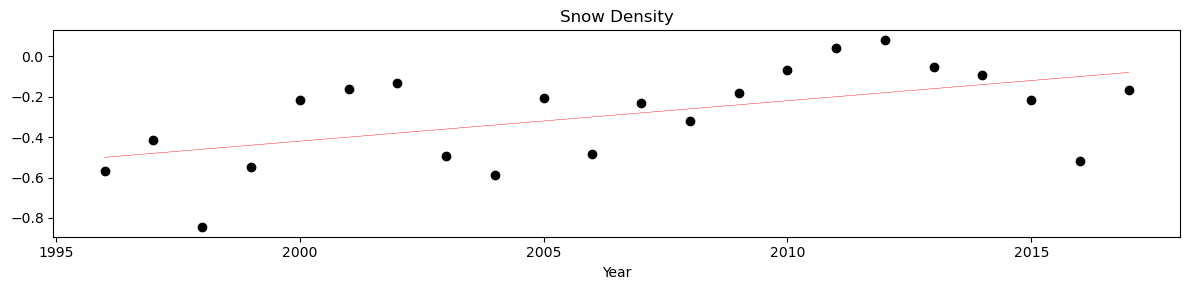

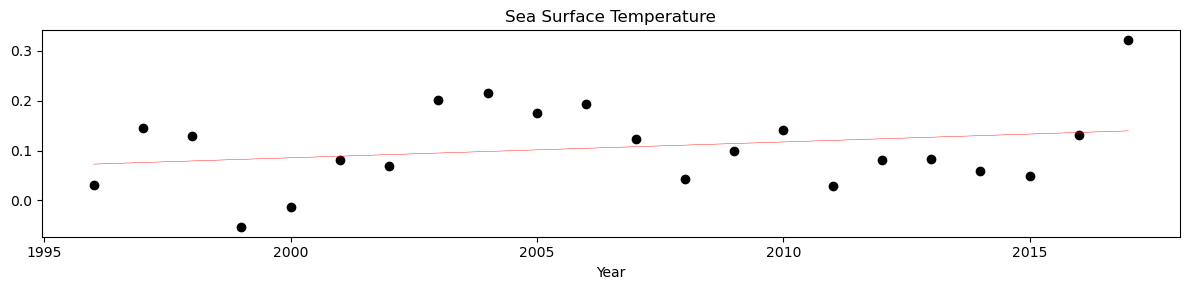

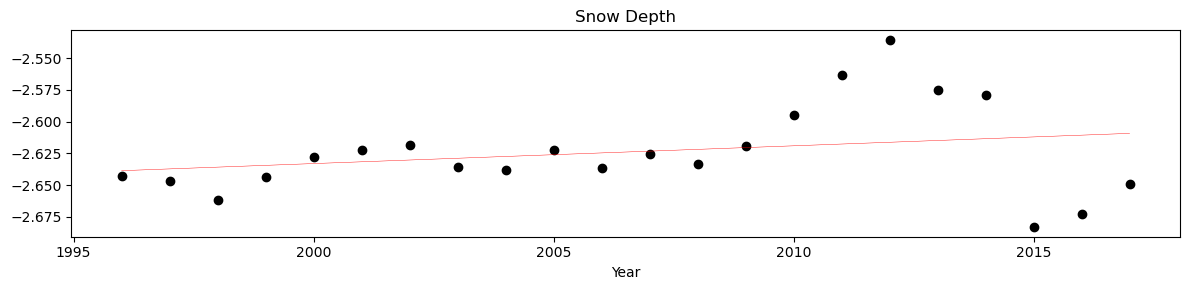

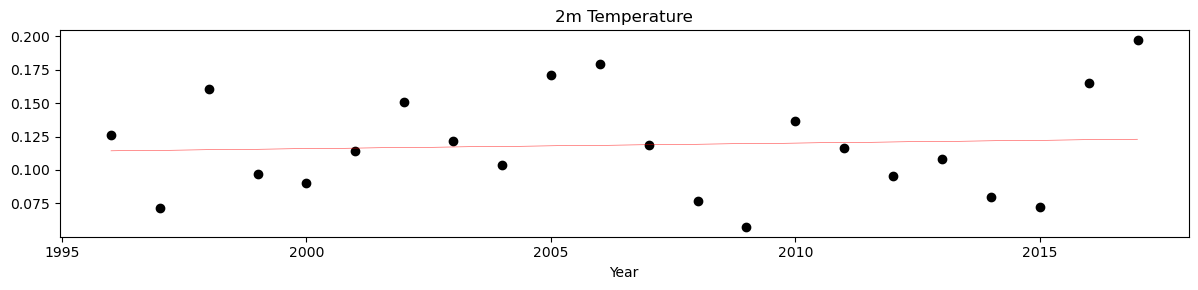

In [35]:
grouped_anomaly['year'] = grouped_anomaly['valid_time'].dt.year
grouped_anomaly['month'] = grouped_anomaly['valid_time'].dt.month

means = grouped_anomaly.groupby('year').agg('mean').reset_index()


def plot_yearly(df, columns, deg):


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        if column == 'siconc':
            title = 'Sea Ice Concentration'
        elif column == 'rsn':
            title = 'Snow Density'
        elif column == 'sst':
            title = 'Sea Surface Temperature'
        elif column == 'sd':
            title = 'Snow Depth'
        elif column == 't2m':
            title = '2m Temperature'
        elif column == 'tp':
            title = 'Total Precipitation'
        elif column == 'avg_smr':
            title = 'Average Snowmelt Rate'


       

        scatter = plt.scatter(df['year'], df[column], c = 'black')

        # add regression line
        z = np.polyfit(df['year'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        p = np.poly1d(z)
        plt.plot(df['year'],p(df['year']), linestyle = "-", c = 'red', linewidth = 0.3)


        plt.xlabel('Year')
        plt.title(title)
        plt.tight_layout()
        plt.show()


plot_yearly(means, columns, 1)

# def plot_yearly(df, columns, deg):
#     fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 8), sharex=True)

#     # Define a dictionary for column titles
#     column_titles = {
#         'siconc': 'Sea Ice Concentration',
#         'rsn': 'Snow Depth',
#         'sst': 'Sea Surface Temperature',
#         'sd': 'Snow Depth',
#         't2m': '2m Temperature',
#         'tp': 'Total Precipitation',
#         'avg_smr': 'Average Snowmelt Rate'
#     }

#     # Ensure axes is iterable even if one column is provided
#     if len(columns) == 1:
#         axes = [axes]

   
    

#     for i, column in enumerate(columns):
#         ax = axes[i]

#         # Filter data (remove zero values)
#         temp_df = df[df[column] != 0].copy()

#         # Extract title or use column name
#         title = column 


#         # # plot all others in light grey and make
#         # for column_rest in columns:
#         #     if column_rest != title:
#         #         temp_df = df[df[column_rest] != 0].copy()
#         #         mean_series = temp_df.groupby("year")[column_rest].mean()
#         #         ax.plot(mean_series.index, mean_series.values, color="grey", linewidth=0.5, alpha = 0.5)

#         # Plot mean time series in bold black
#         mean_series = temp_df.groupby("year")[column].mean()
#         ax.plot(mean_series.index, mean_series.values, color="black", linewidth=0.5, alpha = 1)


#         # Add regression trend line
#         z = np.polyfit(mean_series.index, mean_series.values, deg)
#         p = np.poly1d(z)
#         ax.plot(mean_series.index, p(mean_series.index), linestyle="-", color='black', linewidth=0.5)

#         # Formatting
#         ax.set_ylabel(title)
#         ax.set_yticks([])
#         ax.set_frame_on(False)

#     plt.xlabel("Year")
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_yearly(means, columns, 1)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/2001310195.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = grouped_anomaly.groupby('year').agg('std').reset_index()


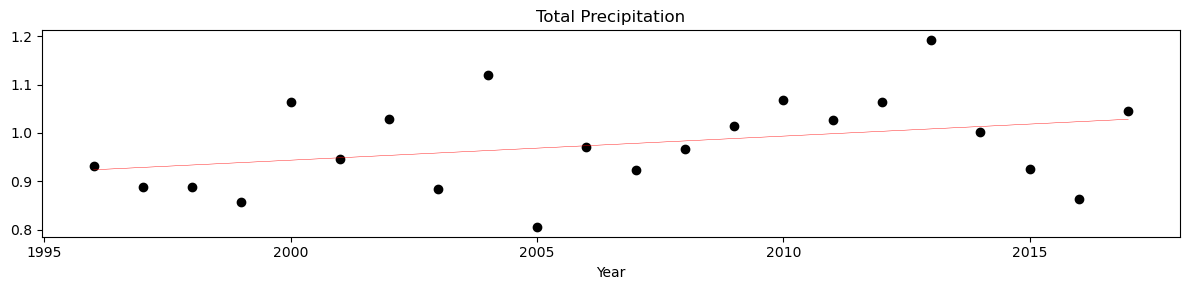

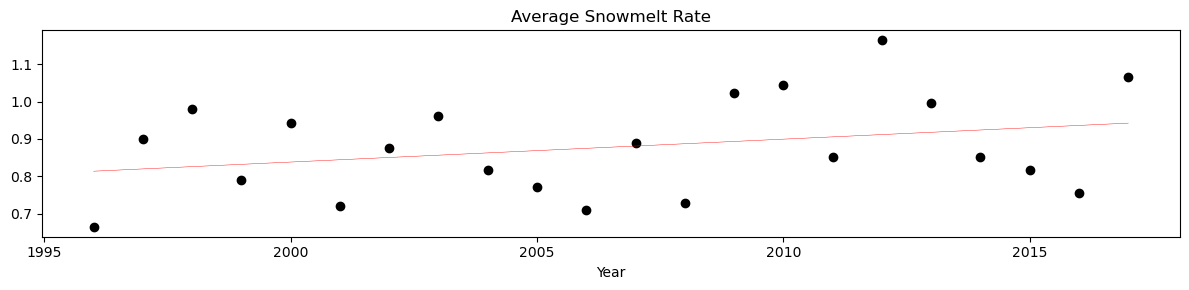

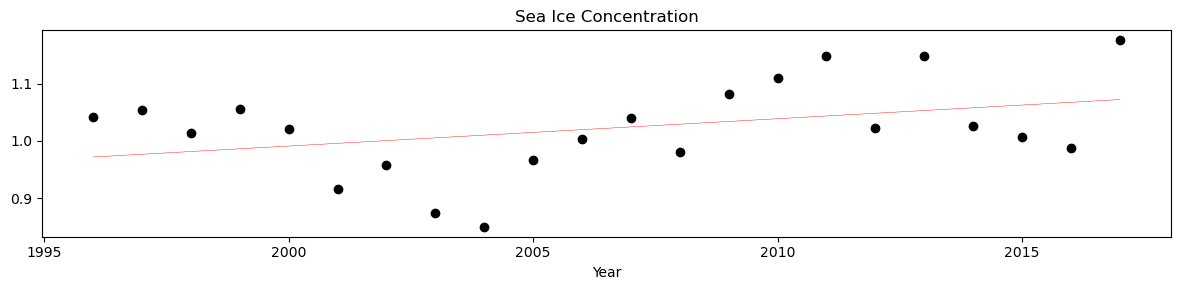

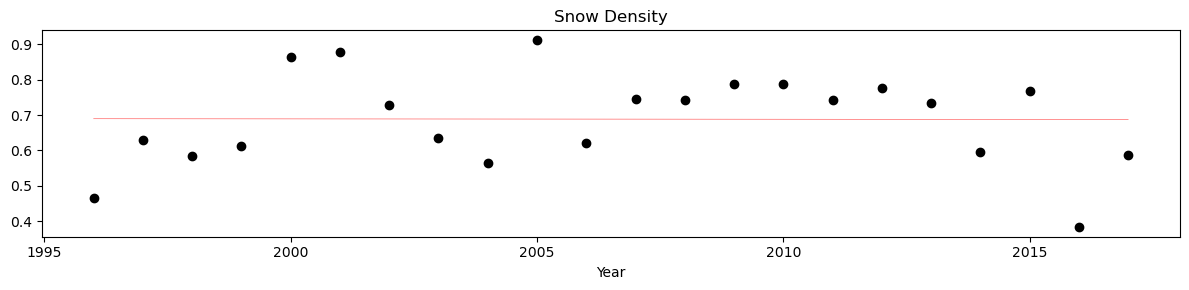

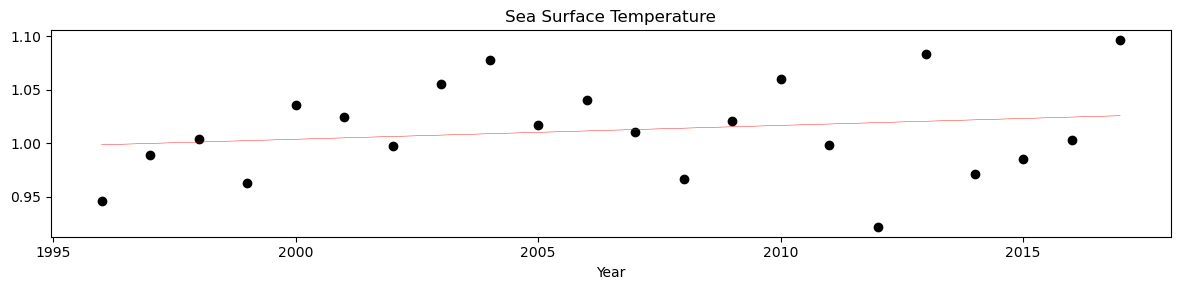

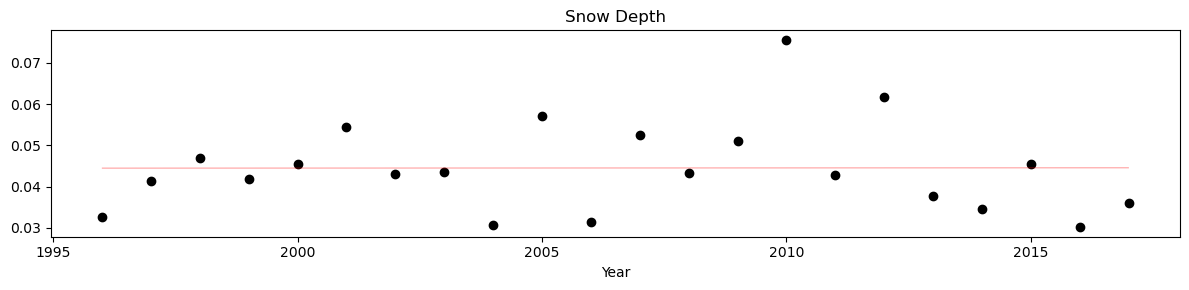

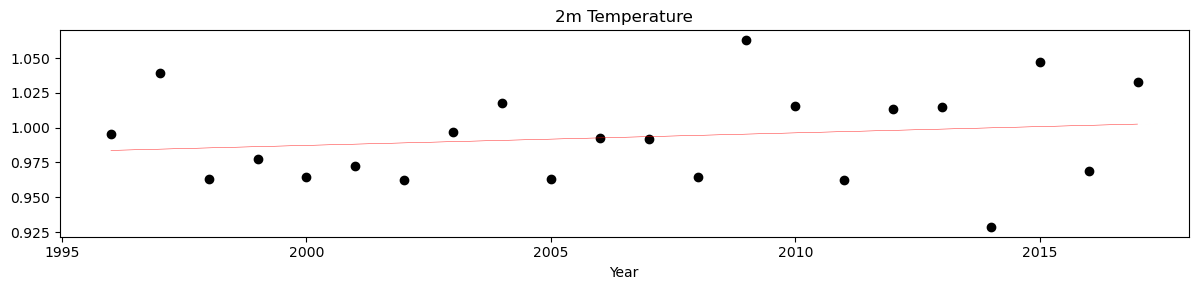

In [36]:
# standard deviations per year
stds = grouped_anomaly.groupby('year').agg('std').reset_index()

plot_yearly(stds, columns, 1)

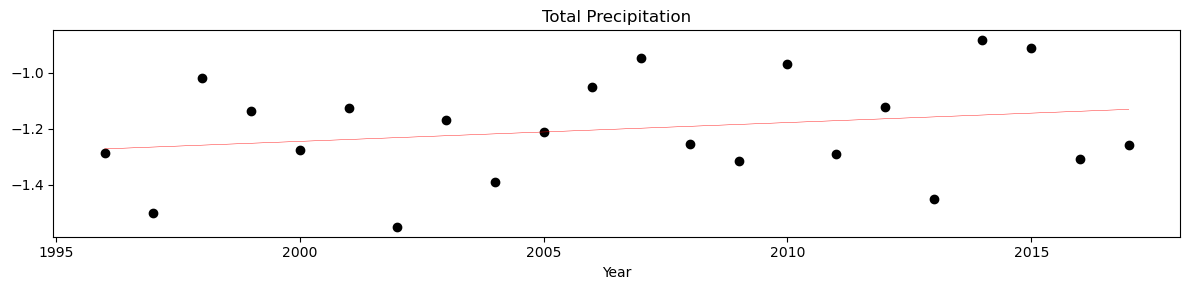

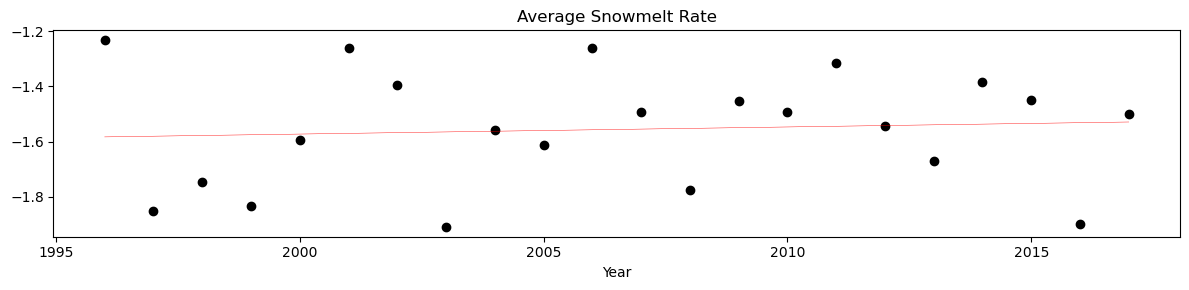

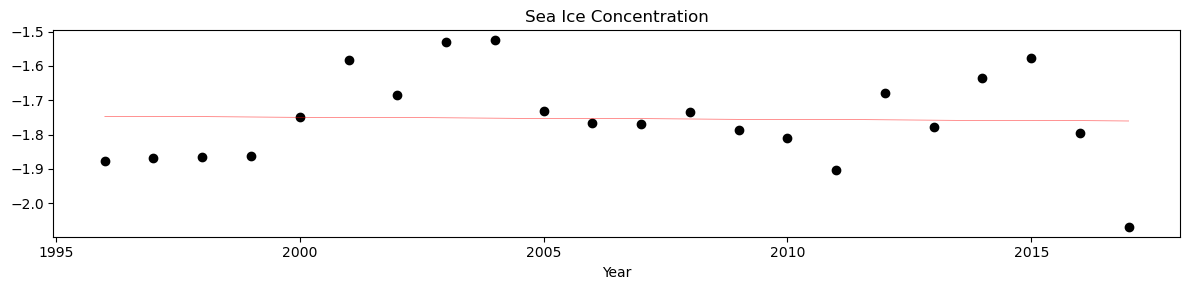

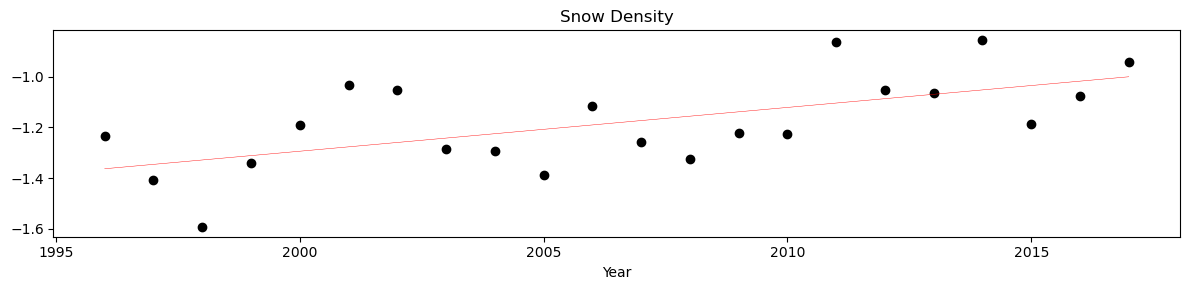

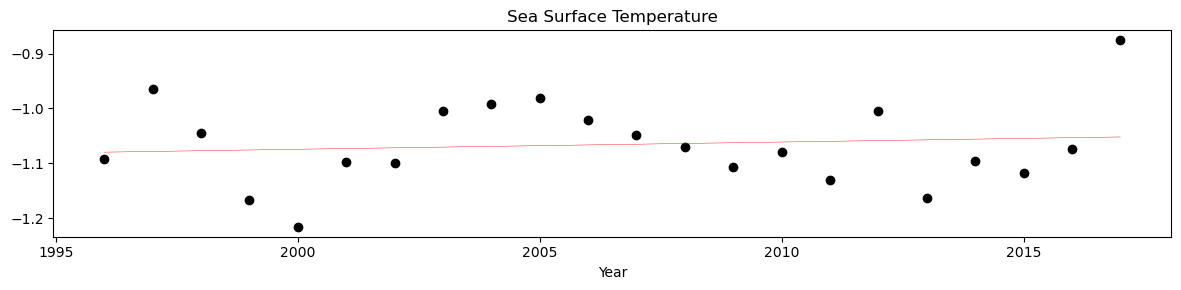

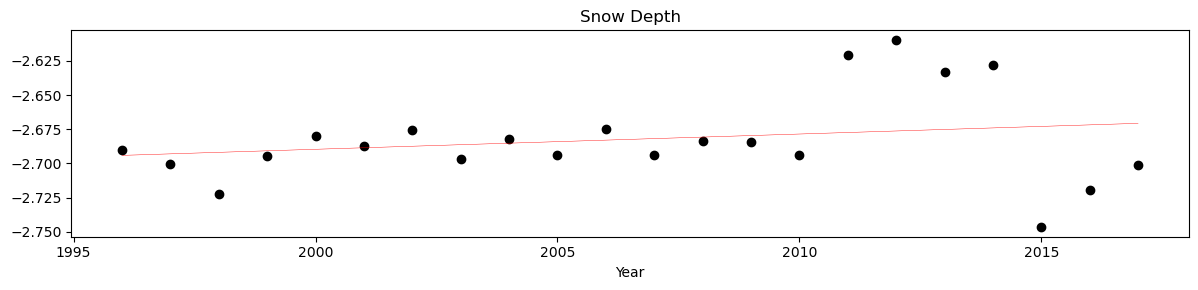

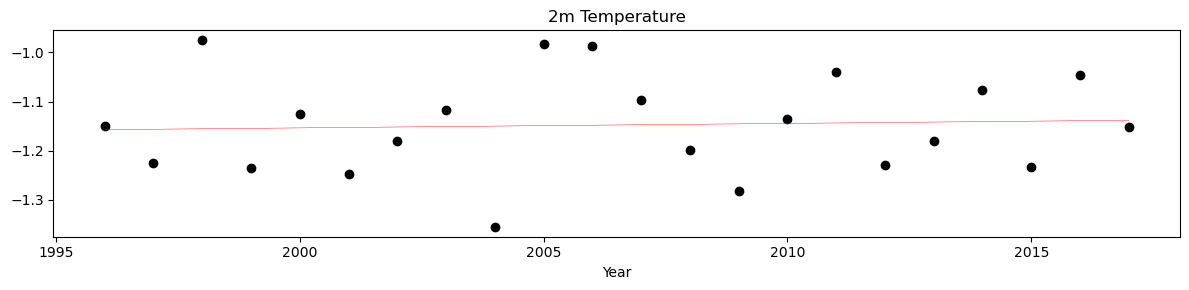

In [37]:
# get minimal and maximal values per year
mins = grouped_anomaly.groupby('year').agg('min').reset_index()
maxs = grouped_anomaly.groupby('year').agg('max').reset_index()

plot_yearly(mins, columns, 1)

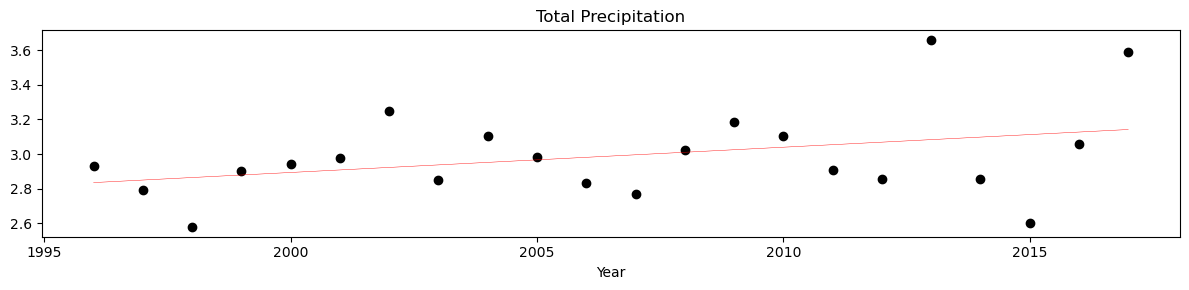

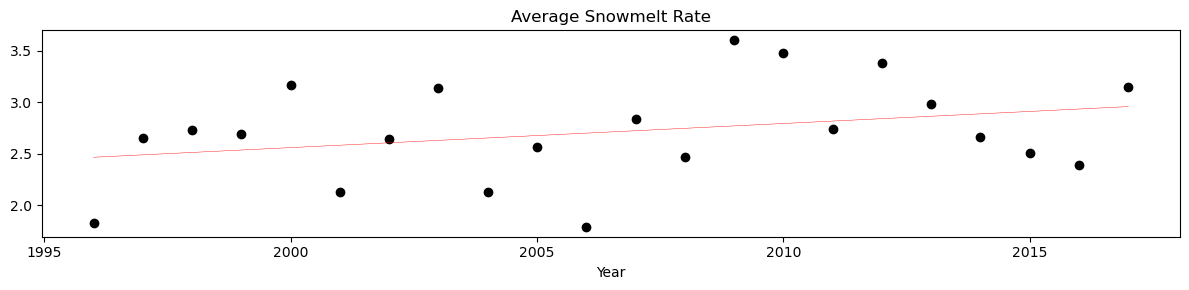

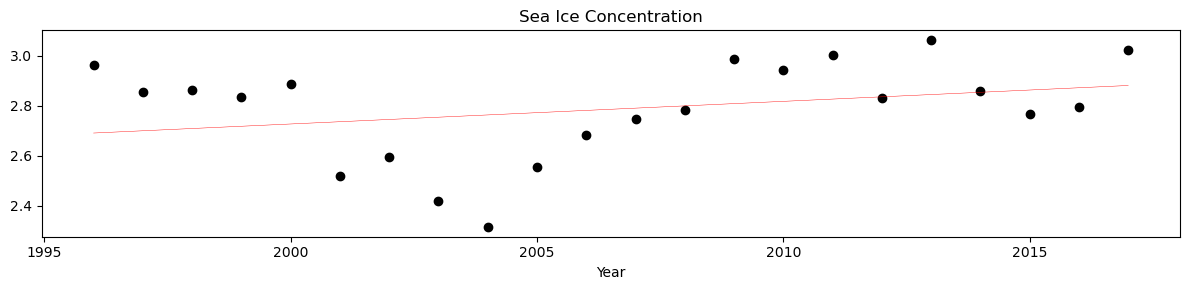

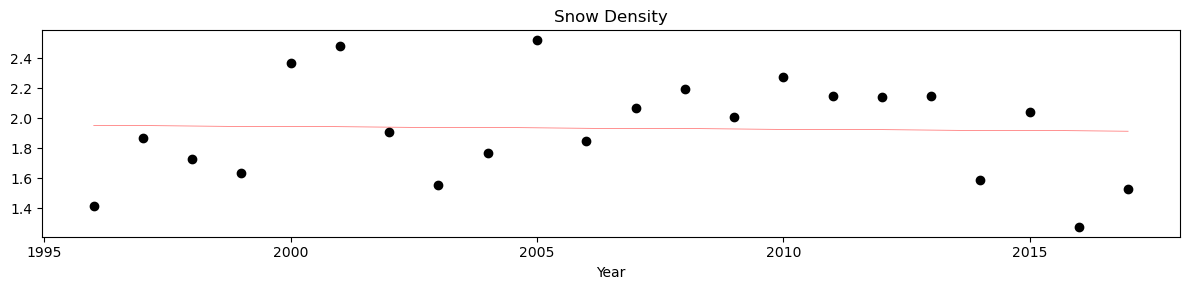

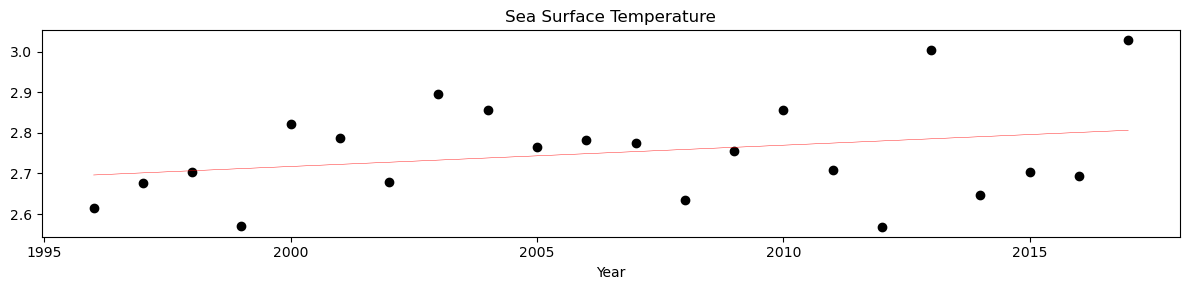

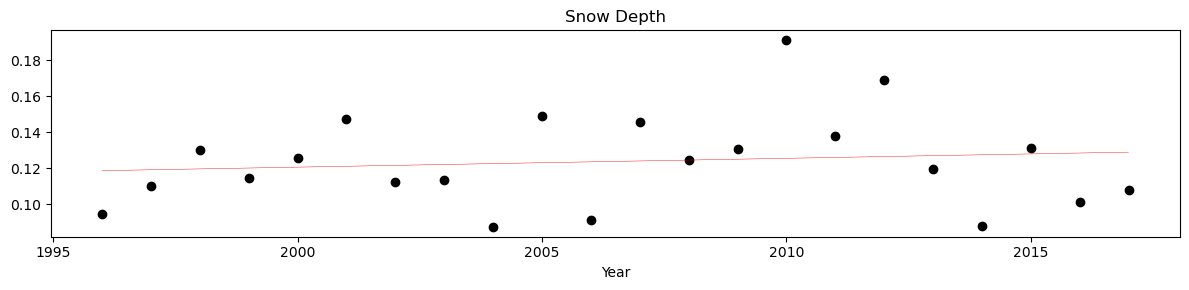

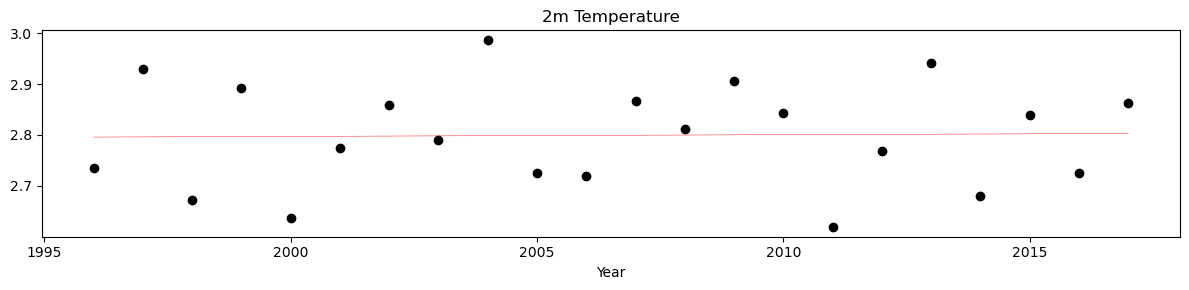

In [38]:
# plot spread per year
diff = maxs.copy()
diff[columns] = maxs[columns] - mins[columns]

plot_yearly(diff, columns, 1)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_90838/2988842444.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stationary = stationary.groupby('year').agg('mean').reset_index()


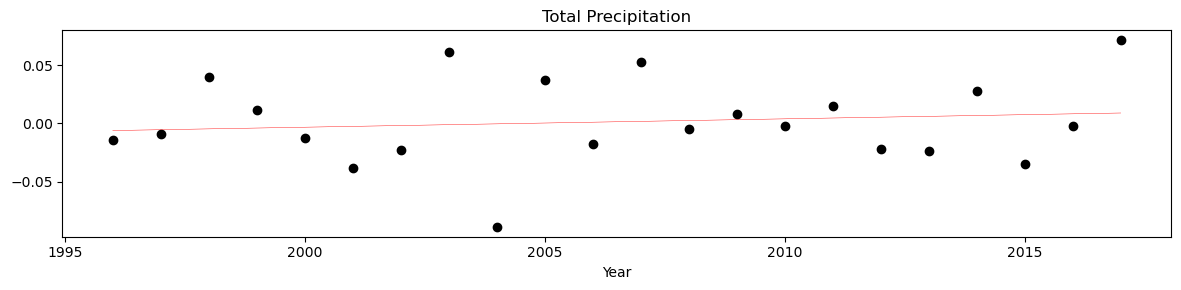

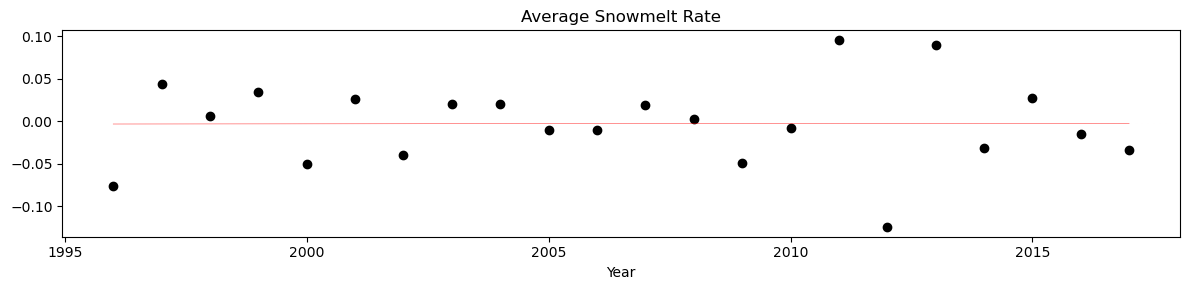

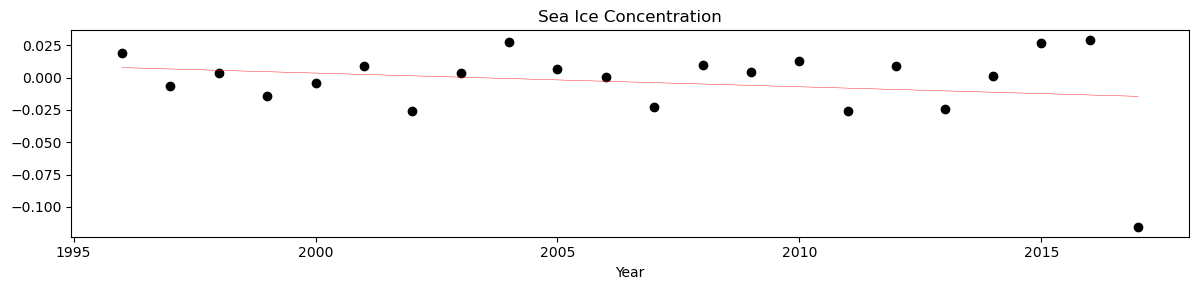

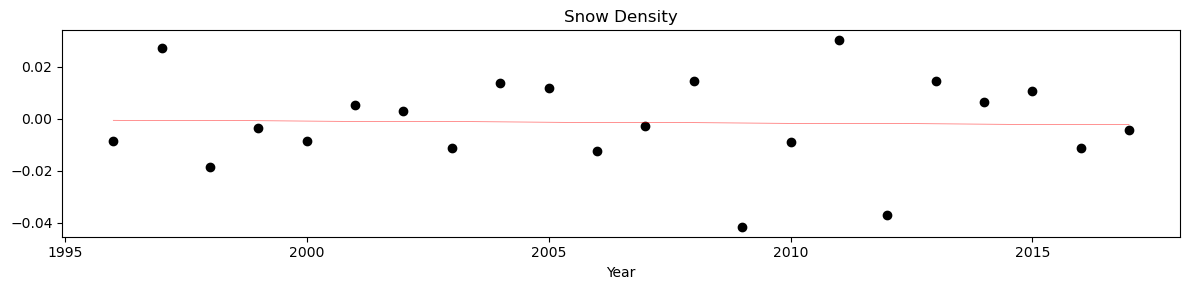

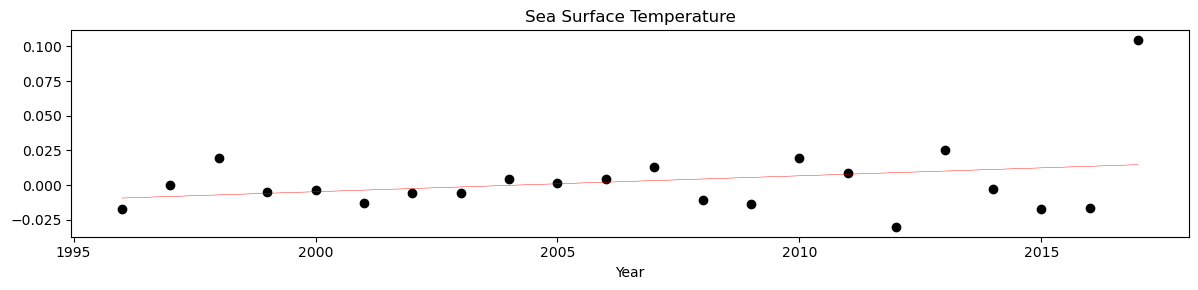

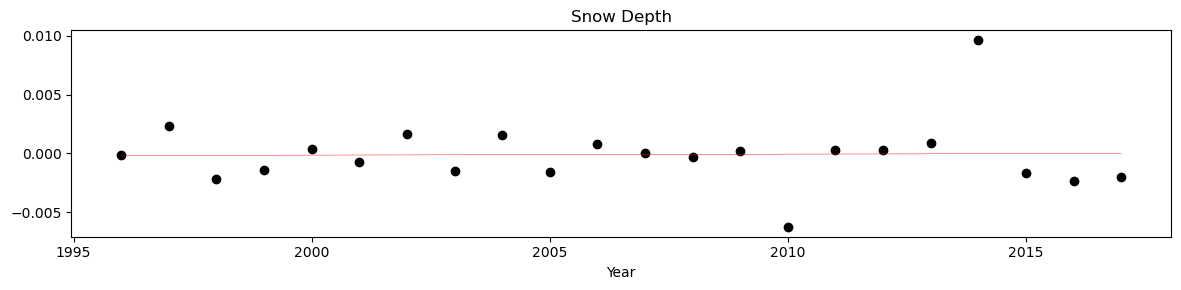

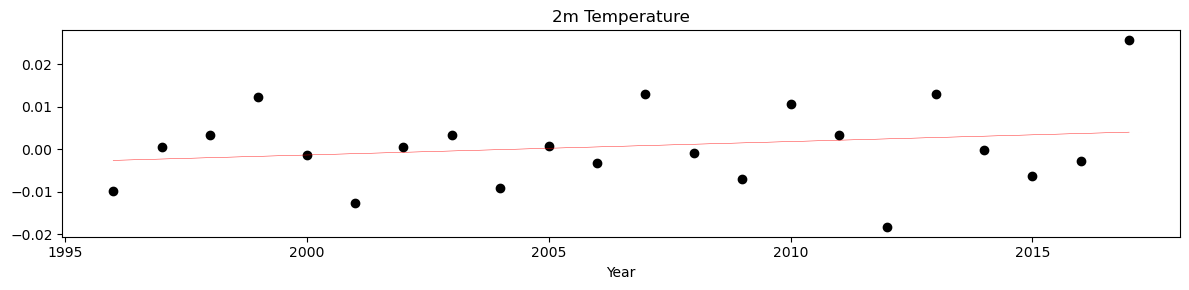

In [39]:
# make it stationary and plot the differences
stationary = grouped_anomaly.copy()
stationary[columns] = stationary[columns]-stationary[columns].shift(-1)

stationary = stationary.groupby('year').agg('mean').reset_index()

plot_yearly(stationary, columns, 1)